# Importation packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import random
import itertools
import warnings
import datetime

from tqdm import tqdm

from pandas.tseries.offsets import BDay

from pathlib import Path  

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from hmmlearn.hmm import GaussianHMM

In [4]:
# Fixer un random state pour reproductibilité
rs = 3

# Data Cleansing

In [6]:
# Load the provided CSV file
file_path = '/Users/andre/Project/sp500_final_df.csv'
sp500_data = pd.read_csv(file_path)

# Display the first few rows of the dataset
sp500_data.head()

,Unnamed: 0,Date,Open,High,Low,Close,Volume,Adjusted,Returns
0,2007-01-03,2007-01-03,1418.030029,1429.420044,1407.859985,1416.599976,3.429160e+09,1416.599976,NaN
1,2007-01-04,2007-01-04,1416.599976,1421.839966,1408.430054,1418.339966,3.004460e+09,1418.339966,0.001228
2,2007-01-05,2007-01-05,1418.339966,1418.339966,1405.750000,1409.709961,2.919400e+09,1409.709961,-0.006085
3,2007-01-08,2007-01-08,1409.260010,1414.979980,1403.969971,1412.839966,2.763340e+09,1412.839966,0.002220
4,2007-01-09,2007-01-09,1412.839966,1415.609985,1405.420044,1412.109985,3.038380e+09,1412.109985,-0.000517


In [8]:
# Set the correct date format
sp500_data['Date'] = pd.to_datetime(sp500_data['Date'])

# Replace the first NaN value with the actual value
sp500_data_filled=sp500_data.drop('Unnamed: 0', axis=1)
sp500_data_filled['Returns'] = sp500_data_filled['Returns'].fillna(-0.00141044)

sp500_data_filled.head()

,Date,Open,High,Low,Close,Volume,Adjusted,Returns
0,2007-01-03,1418.030029,1429.420044,1407.859985,1416.599976,3.429160e+09,1416.599976,-0.001410
1,2007-01-04,1416.599976,1421.839966,1408.430054,1418.339966,3.004460e+09,1418.339966,0.001228
2,2007-01-05,1418.339966,1418.339966,1405.750000,1409.709961,2.919400e+09,1409.709961,-0.006085
3,2007-01-08,1409.260010,1414.979980,1403.969971,1412.839966,2.763340e+09,1412.839966,0.002220
4,2007-01-09,1412.839966,1415.609985,1405.420044,1412.109985,3.038380e+09,1412.109985,-0.000517


In [10]:
filepath = Path('/Users/andre/sp500_data.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
sp500_data_filled.to_csv(filepath) 

# Statistiques descriptives

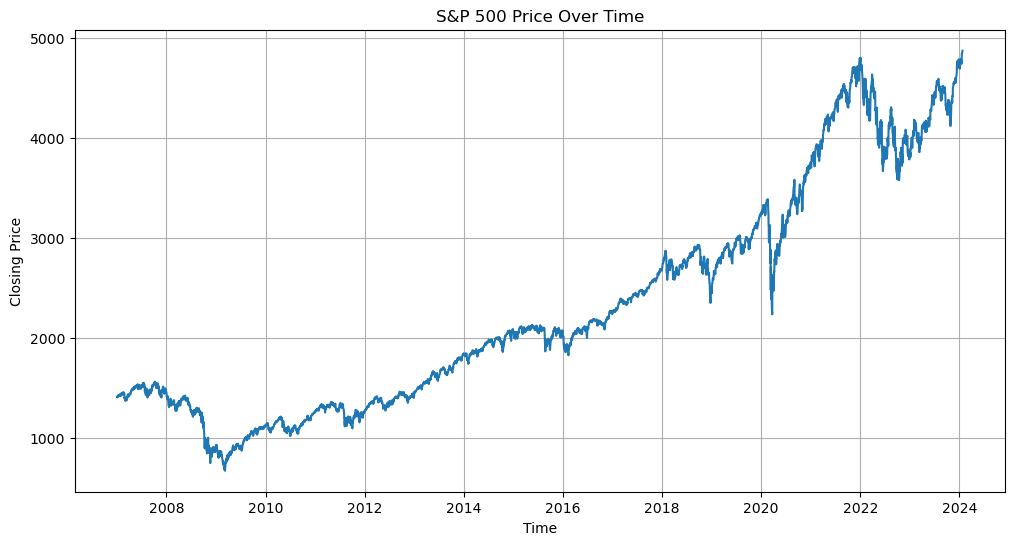

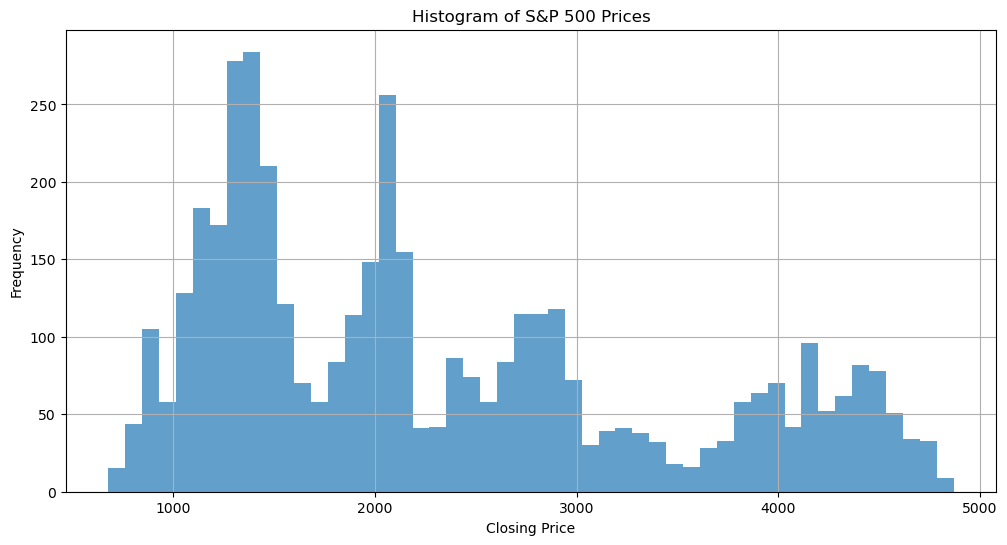

In [12]:
# Plotting the returns
plt.figure(figsize=(12, 6))
plt.plot(sp500_data_filled['Date'], sp500_data_filled['Close'])
plt.title('S&P 500 Price Over Time')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.grid(True)
plt.show()

# Histogram of the returns
plt.figure(figsize=(12, 6))
plt.hist(sp500_data_filled['Close'], bins=50, alpha=0.7)
plt.title('Histogram of S&P 500 Prices')
plt.xlabel('Closing Price')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

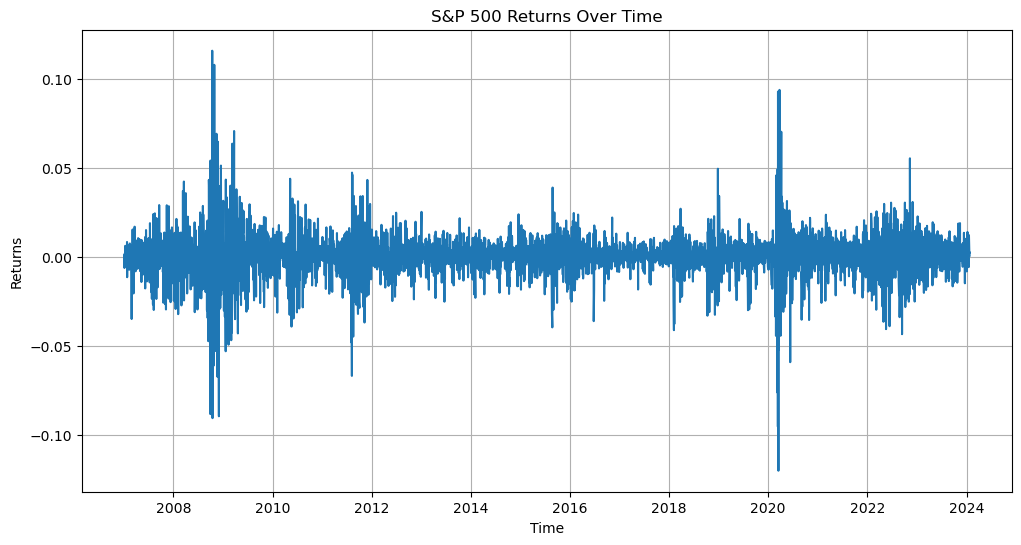

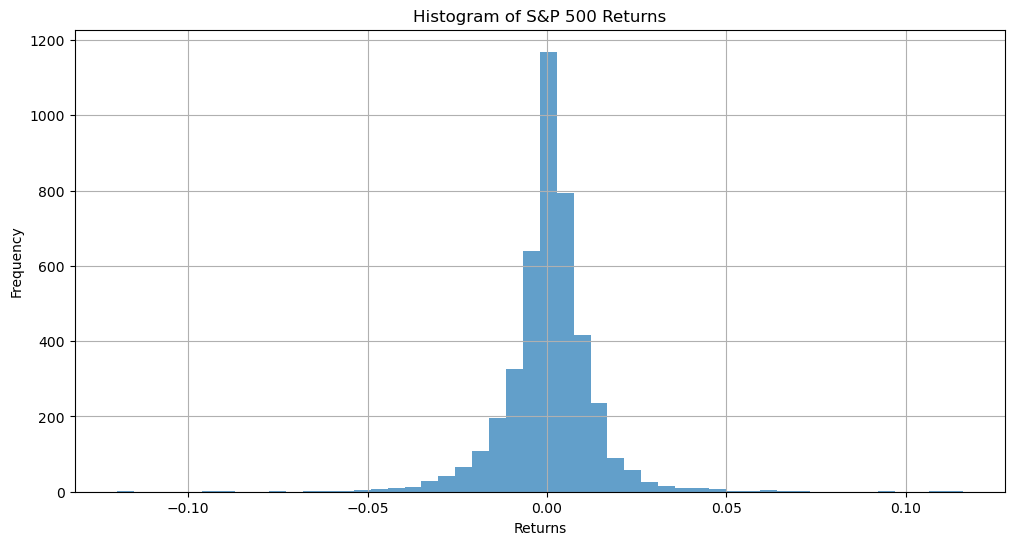

In [14]:
# Plotting the Returns
plt.figure(figsize=(12, 6))
plt.plot(sp500_data_filled['Date'], sp500_data_filled['Returns'])
plt.title('S&P 500 Returns Over Time')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.grid(True)
plt.show()

# Histogram of Variation
plt.figure(figsize=(12, 6))
plt.hist(sp500_data_filled['Returns'], bins=50, alpha=0.7)
plt.title('Histogram of S&P 500 Returns')
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# ARIMA

In [16]:
# Perform Augmented Dickey-Fuller test
adf_test = adfuller(sp500_data_filled['Returns'])

# Extract and display the p-value
adf_pvalue = adf_test[1]

adf_pvalue # We can reject the null hypothesis, indicating that the series is stationary

adf_results = pd.Series(adf_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in adf_test[4].items():
    adf_results[f'Critical Value ({key})'] = value

adf_results

Test Statistic                -1.621619e+01
p-value                        3.940309e-29
#Lags Used                     1.700000e+01
Number of Observations Used    4.276000e+03
Critical Value (1%)           -3.431880e+00
Critical Value (5%)           -2.862216e+00
Critical Value (10%)          -2.567130e+00
dtype: float64

/Users/andre/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


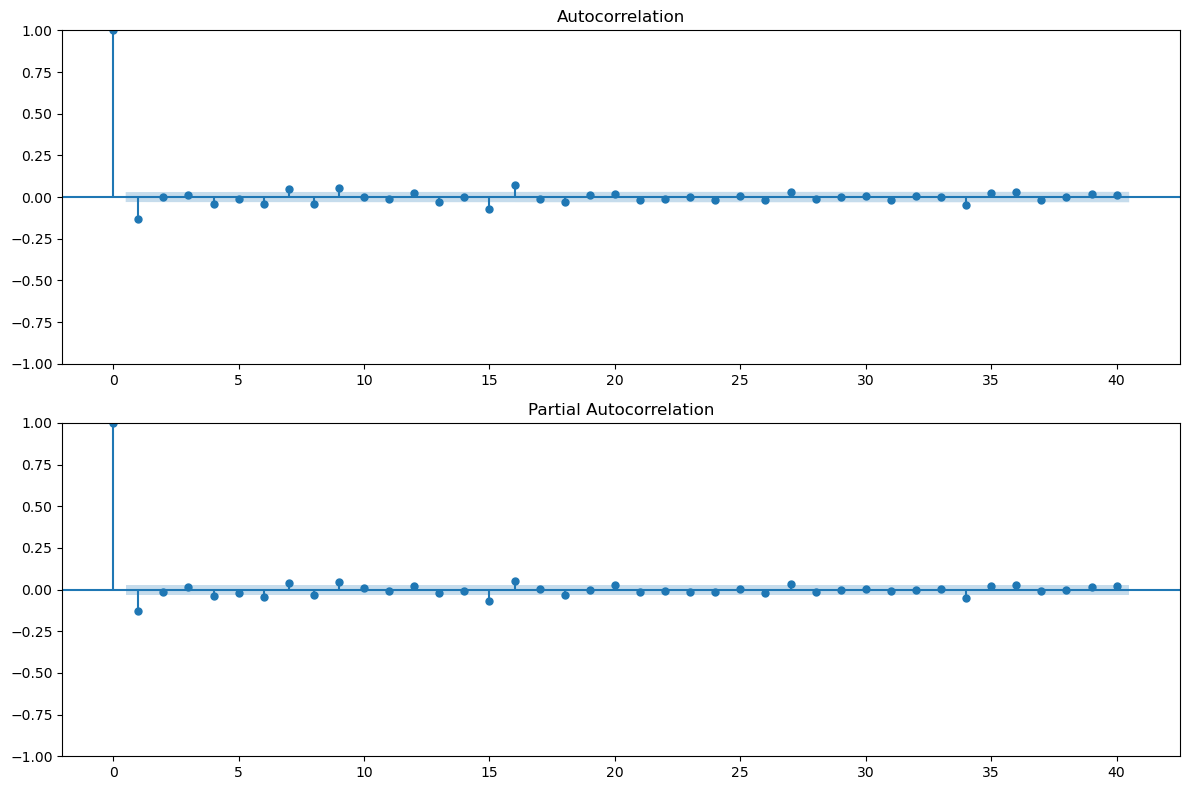

In [18]:
sp500_diff = sp500_data_filled['Returns']
# Plotting ACF and PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# ACF plot
plot_acf(sp500_diff, ax=ax1, lags=40)

# PACF plot
plot_pacf(sp500_diff, ax=ax2, lags=40)

plt.tight_layout()
plt.show()


In [20]:
# Suppress warnings for model convergence issues during the grid search
warnings.filterwarnings("ignore")

# Define the p, d, and q parameters to take values between 0 and 5
p = d = q = range(0, 6)

# Generate all different combinations of p, d(=0), and q triplets
pdq = list(itertools.product(p, [0], q))

# Search for the best ARIMA model based on AIC
best_aic = float("inf")
best_pdq = None
best_model = None

for param in pdq:
    try:
        model = ARIMA(sp500_data['Returns'], order=param)
        results = model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_pdq = param
            best_model = results
    except:
        continue

best_aic, best_pdq

(-25348.380278022083, (4, 0, 5))

In [22]:
# Fitting the ARIMA(4,0,5) model based on the best parameters found
model_405 = ARIMA(sp500_data['Returns'], order=(4, 0, 5))
results_405 = model_405.fit()
results_405.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Returns   No. Observations:                 4294
Model:                 ARIMA(4, 0, 5)   Log Likelihood               12685.190
Date:                Tue, 30 Jan 2024   AIC                         -25348.380
Time:                        15:11:57   BIC                         -25278.366
Sample:                             0   HQIC                        -25323.651
                               - 4294                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      1.961      0.050    2.31e-07       0.001
ar.L1         -0.6675      0.207     -3.219      0.001      -1.074      -0.261
ar.L2          0.4031      0.223      1.811      0.070      -0.033       0.839
ar.L3         -0.0094      0.221     -0.042      0.966      -0.443       0.424
ar.L4         -0.5531      0.180     -3.066      0.002      -0.907      -0.200
ma.L1          0.5414      0.209      2.596      0.009       0.133       0.950
ma.L2         -0.4653      0.203     -2.290      0.022      -0.863      -0.067
ma.L3          0.0634      0.221      0.287      0.774      -0.369       0.496
ma.L4          0.5067      0.161      3.154      0.002       0.192       0.821
ma.L5         -0.0782      0.017     -4.499      0.000      -0.112      -0.044
sigma2         0.0002   1.49e-06    106.363      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             20339.83
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               0.64   Skew:                            -0.50
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

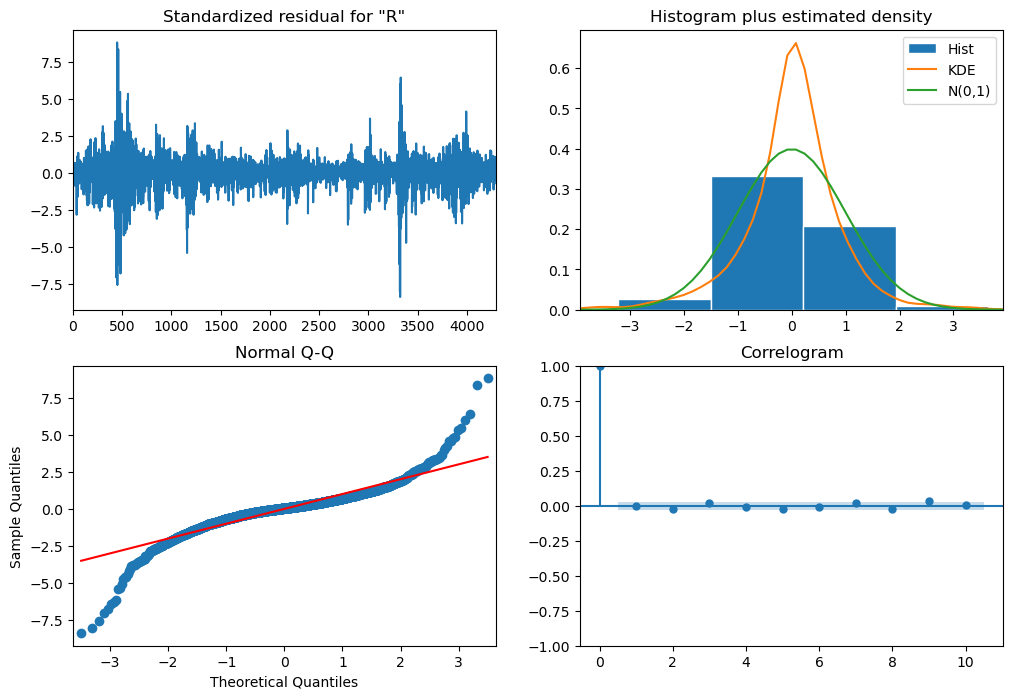

In [24]:
# Model diagnostics
arima_diagnostics = results_405.plot_diagnostics(figsize=(12,8))
plt.show()

* Standardized Residuals: Les résidus semblent fluctuer autour d'une moyenne de zéro, ce qui semblerait cohérent avec une. Cependant, il y a des pics indiquant des moments d'instabilité financière : crise de 2009 et crise covid-19.

* Histogramme et Densité Estimée : Ladensité des résidus standardisés est légèrement asymétrique, suivent pas parfaitement une loi normale. Cela pourrait indiquer la présence de mécanismes non linéaires dans les données que le modèle ARIMA ne peut pas capturer.

* Normal Q-Q Plot: La plupart des points se situent le long de la ligne. Or, on peut aussi voir que la distribution des résidus a des queues plus épaisses que la loi normale, un phénomène courant dans les séries temporelles financières.

* Corrélogramme (graphique ACF) : Le corrélogramme ne montre aucune autocorrélation significative dans les résidus, suggérant que le modèle capture bien la structure temporelle.

## Test de généralité du modèle

In [26]:
# Define the split point for the last 20% of the data
split_point = int(len(sp500_data) * 0.8)

# Split the data into training and test sets
train = sp500_data['Returns'][:split_point]
test = sp500_data['Returns'][split_point:]

# Train
model_train = ARIMA(train, order=(4,0,5))
train_fit = model_train.fit()

In [28]:
def color_variation(value):
    """
    Colors positive variations in green and negative variations in red.
    """
    color = 'red' if value < 0 else 'green'
    return f'color: {color}'

In [30]:
# Forecast for the next 22 business days
forecast_steps_month = 22  # Approximate number of business days in a month
forecast_405_month = results_405.get_forecast(steps=forecast_steps_month)

# Extract the forecast and confidence intervals for the month
forecast_values = forecast_405_month.predicted_mean
conf_int_month = forecast_405_month.conf_int(alpha=0.05)  # 95% confidence interval

# Create a DataFrame for the forecast and confidence intervals
forecast_df_month = pd.DataFrame({
    'Forecast': forecast_values,
    'Lower CI': conf_int_month.iloc[:, 0],
    'Upper CI': conf_int_month.iloc[:, 1]
})

# Set the index to business days starting from the last date in the original data
forecast_df_month['Date'] = pd.date_range(start=sp500_data['Date'].max(), periods=forecast_steps_month + 1, closed='right', freq=BDay())

# Calculate the variation (difference) between consecutive forecast values
forecast_df_month['Forecast'] = forecast_df_month['Forecast'].diff()
forecast_df_month['Variation (%)'] = forecast_df_month['Forecast'] * 100

forecast_df_month = forecast_df_month[['Date', 'Forecast', 'Lower CI', 'Upper CI', 'Variation (%)']]  # Display the first few rows of the forecast dataframe
forecast_df_month

,Date,Forecast,Lower CI,Upper CI,Variation (%)
4294,2024-01-25,NaN,-0.024858,0.024526,NaN
4295,2024-01-26,0.000168,-0.024885,0.024890,0.016842
4296,2024-01-29,0.000239,-0.024652,0.025135,0.023929
4297,2024-01-30,-0.000031,-0.024684,0.025106,-0.003084
4298,2024-01-31,0.000439,-0.024255,0.025555,0.043882
4299,2024-02-01,-0.000342,-0.024598,0.025213,-0.034200
4300,2024-02-02,0.000273,-0.024334,0.025496,0.027309
4301,2024-02-05,-0.000307,-0.024650,0.025198,-0.030718
4302,2024-02-06,0.000076,-0.024577,0.025275,0.007561
4303,2024-02-07,0.000012,-0.024568,0.025291,0.001231


In [32]:
# Apply the styling to the DataFrame
styled_df = forecast_df_month.style.applymap(color_variation, subset=['Variation (%)'])
styled_df

,Date,Forecast,Lower CI,Upper CI,Variation (%)
4294,2024-01-25 00:00:00,nan,-0.024858,0.024526,nan
4295,2024-01-26 00:00:00,0.000168,-0.024885,0.024890,0.016842
4296,2024-01-29 00:00:00,0.000239,-0.024652,0.025135,0.023929
4297,2024-01-30 00:00:00,-0.000031,-0.024684,0.025106,-0.003084
4298,2024-01-31 00:00:00,0.000439,-0.024255,0.025555,0.043882
4299,2024-02-01 00:00:00,-0.000342,-0.024598,0.025213,-0.034200
4300,2024-02-02 00:00:00,0.000273,-0.024334,0.025496,0.027309
4301,2024-02-05 00:00:00,-0.000307,-0.024650,0.025198,-0.030718
4302,2024-02-06 00:00:00,0.000076,-0.024577,0.025275,0.007561
4303,2024-02-07 00:00:00,0.000012,-0.024568,0.025291,0.001231


In [34]:
ARIMA_train = model_train.fit()
ARIMA_train_forecast = ARIMA_train.get_forecast(steps=(len(test)))
y_pred = ARIMA_train_forecast.predicted_mean
MAE = mean_absolute_error(test, y_pred)
MAE

0.008235484470293743

On obtient une MAE de 0.008235484470293743. Ceci veut dire que les prédictions du modèle sont déviées de 0.8235% des vraies valeurs. Ceci indique que le modèle est extrêmement imprécis considérant que le les rendements prédits sont d'ordre de 0.1%.

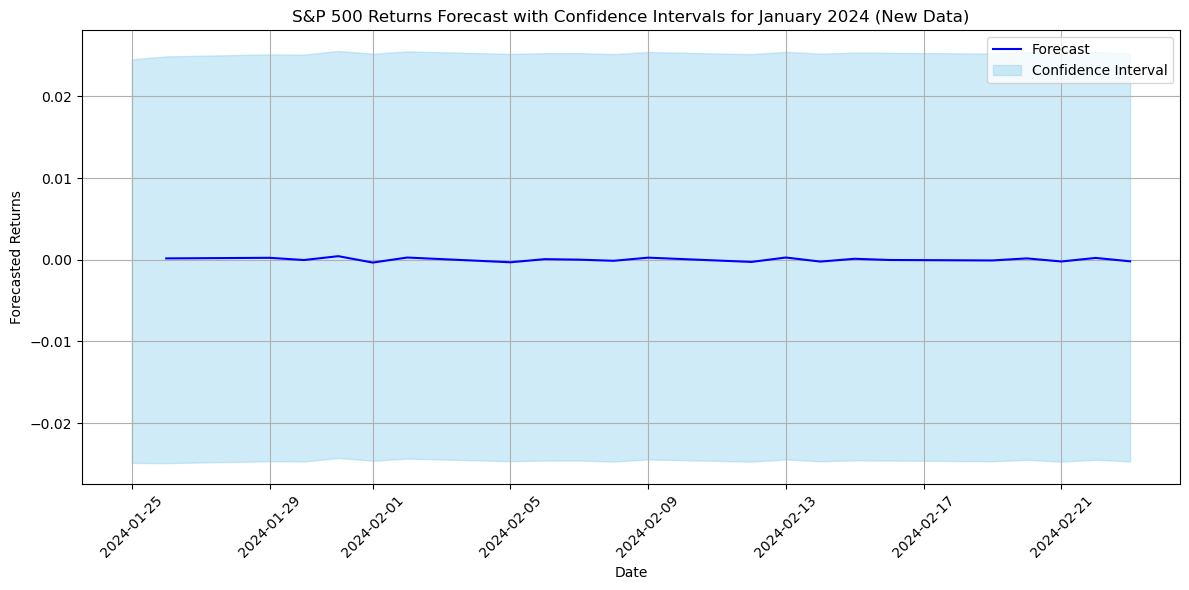

In [36]:
# Plotting Predictions with CI
plt.figure(figsize=(12, 6))
plt.plot(forecast_df_month['Date'], forecast_df_month['Forecast'], label='Forecast', color='blue')
plt.fill_between(forecast_df_month['Date'], forecast_df_month['Lower CI'], forecast_df_month['Upper CI'], color='skyblue', alpha=0.4, label='Confidence Interval')
plt.title('S&P 500 Returns Forecast with Confidence Intervals for January 2024 (New Data)')
plt.xlabel('Date')
plt.ylabel('Forecasted Returns')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


# HMM

## Nombre d'états cachés optimal

In [11]:
# Charger les données et préparation pour HMM
data = sp500_data_filled
scaler = StandardScaler()
X = data['Returns'].values.reshape(-1, 1)

# Normalisation (pour convergence)
X_scaled = scaler.fit_transform(X)

In [13]:
X_scaled.shape

(4294, 1)

In [21]:
rs

3

In [29]:
# Déterminer le nb d'états cachés optimal
aic = []
bic = []
lls = []
ns = [3, 4, 5, 6, 7, 8]
for n in ns:
    best_ll = None
    best_model = None
    for i in range(10):
        h = GaussianHMM(n, n_iter=50, tol=1e-4, random_state=rs)
        h.fit(X_scaled)
        score = h.score(X_scaled)
        if not best_ll or best_ll < best_ll:
            best_ll = score
            best_model = h
    aic.append(best_model.aic(X_scaled))
    bic.append(best_model.bic(X_scaled))
    lls.append(best_model.score(X_scaled))

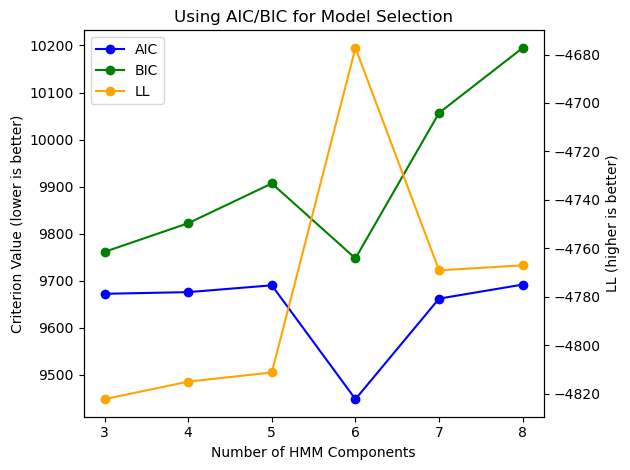

In [31]:
# Visualize our results: a clear minimum is seen for 4 components which matches our expectation.

fig, ax = plt.subplots()
ln1 = ax.plot(ns, aic, label="AIC", color="blue", marker="o")
ln2 = ax.plot(ns, bic, label="BIC", color="green", marker="o")
ax2 = ax.twinx()
ln3 = ax2.plot(ns, lls, label="LL", color="orange", marker="o")

ax.legend(handles=ax.lines + ax2.lines)
ax.set_title("Using AIC/BIC for Model Selection")
ax.set_ylabel("Criterion Value (lower is better)")
ax2.set_ylabel("LL (higher is better)")
ax.set_xlabel("Number of HMM Components")
fig.tight_layout()

plt.show()

Best model : 5 states

## Création du modèle

On utilise 3 nouvelles variables:

1) Changement Fractionnel des Prix d'Ouverture et de Clôture (fracocp) : Ce paramètre reflète le changement relatif du prix de l'action entre l'ouverture et la clôture de la journée de trading. C'est un indicateur direct de la performance de l'action ce jour-là.

2) Changement Fractionnel des Prix les Plus Élevés (frachp) : Cela mesure le changement relatif dans le prix le plus élevé de l'action sur une période spécifique. Cela aide à comprendre la performance maximale de l'action en trading. Les prix les plus élevés sont souvent associés au niveau de résistance de l'action - un point où l'intérêt de vente surpasse la pression d'achat et le prix commence à baisser à nouveau.

3) Changement Fractionnel des Prix les Plus Bas (fraclp) : Cela suit le changement relatif dans le prix le plus bas de l'action sur une période donnée. Les prix les plus bas sont liés aux niveaux de support - un niveau de prix où on peut s'attendre à une pause de la tendance baissière en raison d'une concentration de la demande. Comprendre ces niveaux peut être crucial pour identifier les renversements potentiels dans la tendance des prix de l'action.

In [33]:
def augment_features(dataframe):
    fracocp = (dataframe['Close']-dataframe['Open'])/dataframe['Open']
    frachp = (dataframe['High']-dataframe['Open'])/dataframe['Open']
    fraclp = (dataframe['Open']-dataframe['Low'])/dataframe['Open']
    new_dataframe = pd.DataFrame({'delOpenClose': fracocp,
                                 'delHighOpen': frachp,
                                 'delLowOpen': fraclp})
    new_dataframe.set_index(dataframe['Date'])
    
    return new_dataframe

In [34]:
def extract_features(dataframe):
    return np.column_stack((dataframe['delOpenClose'], dataframe['delHighOpen'], dataframe['delLowOpen']))

In [41]:
len(sp500_data_filled)

4294

In [45]:
# Split the data into training and test sets
split_point = int(0.8*len(sp500_data_filled))
train_data = sp500_data_filled[:split_point]
test_data = sp500_data_filled[split_point:]


features = extract_features(augment_features(train_data))

feature_train_data = augment_features(train_data)
features_train = extract_features(feature_train_data)


In [84]:
test_augmented = augment_features(test_data)
fracocp = test_augmented['delOpenClose']
frachp = test_augmented['delHighOpen']
fraclp = test_augmented['delLowOpen']

sample_space_fracocp = np.linspace(fracocp.min(), fracocp.max(), 50)
sample_space_fraclp = np.linspace(fraclp.min(), frachp.max(), 10)
sample_space_frachp = np.linspace(frachp.min(), frachp.max(), 10)

# Vecteurs contenant toutes les combinaisons des valeurs des 3 échantillons précédents
possible_outcomes = np.array(list(itertools.product(sample_space_fracocp, sample_space_frachp, sample_space_fraclp)))

We use the data of the last 50 (latent) days to predict the closing price of the current day, and we repeat those for 300 days (this value does not matter at all)

## Nb d'Etats optimal 

In [49]:
num_latent_days_values = [10, 20, 30, 40, 50, 60]
baseline_num_latent_days = 50
n_components_values = [4, 5, 6, 8, 10, 12]
baseline_n_componets = 5
num_days_to_predict = 30 # We don't need to predict as many days as before

In [51]:
# Comparant MAE pour trouver le nb d'états optimal
mae_num_components = []
for num_component in n_components_values:
    model = GaussianHMM(n_components=num_component, random_state = rs)
    model.fit(features_train)
    predicted_close_prices = []
    for i in tqdm(range(num_days_to_predict)):
        # Calculate start and end indices
        previous_data_start_index = max(0, i - baseline_num_latent_days)
        previous_data_end_index = max(0, i)
        # Acquire test data features for these days
        previous_data = extract_features(augment_features(test_data.iloc[previous_data_start_index:previous_data_end_index]))

        outcome_scores = []
        for outcome in possible_outcomes:
            # Append each outcome one by one with replacement to see which sequence generates the highest score
            total_data = np.row_stack((previous_data, outcome))
            outcome_scores.append(model.score(total_data))

        # Take the most probable outcome as the one with the highest score
        most_probable_outcome = possible_outcomes[np.argmax(outcome_scores)]
        predicted_close_prices.append(test_data.iloc[i]['Open'] * (1 + most_probable_outcome[0]))
    mae_num_components.append((abs(test_data.iloc[0:num_days_to_predict]['Close'] - predicted_close_prices)).mean())

100%|██████████| 30/30 [00:19<00:00,  1.53it/s]


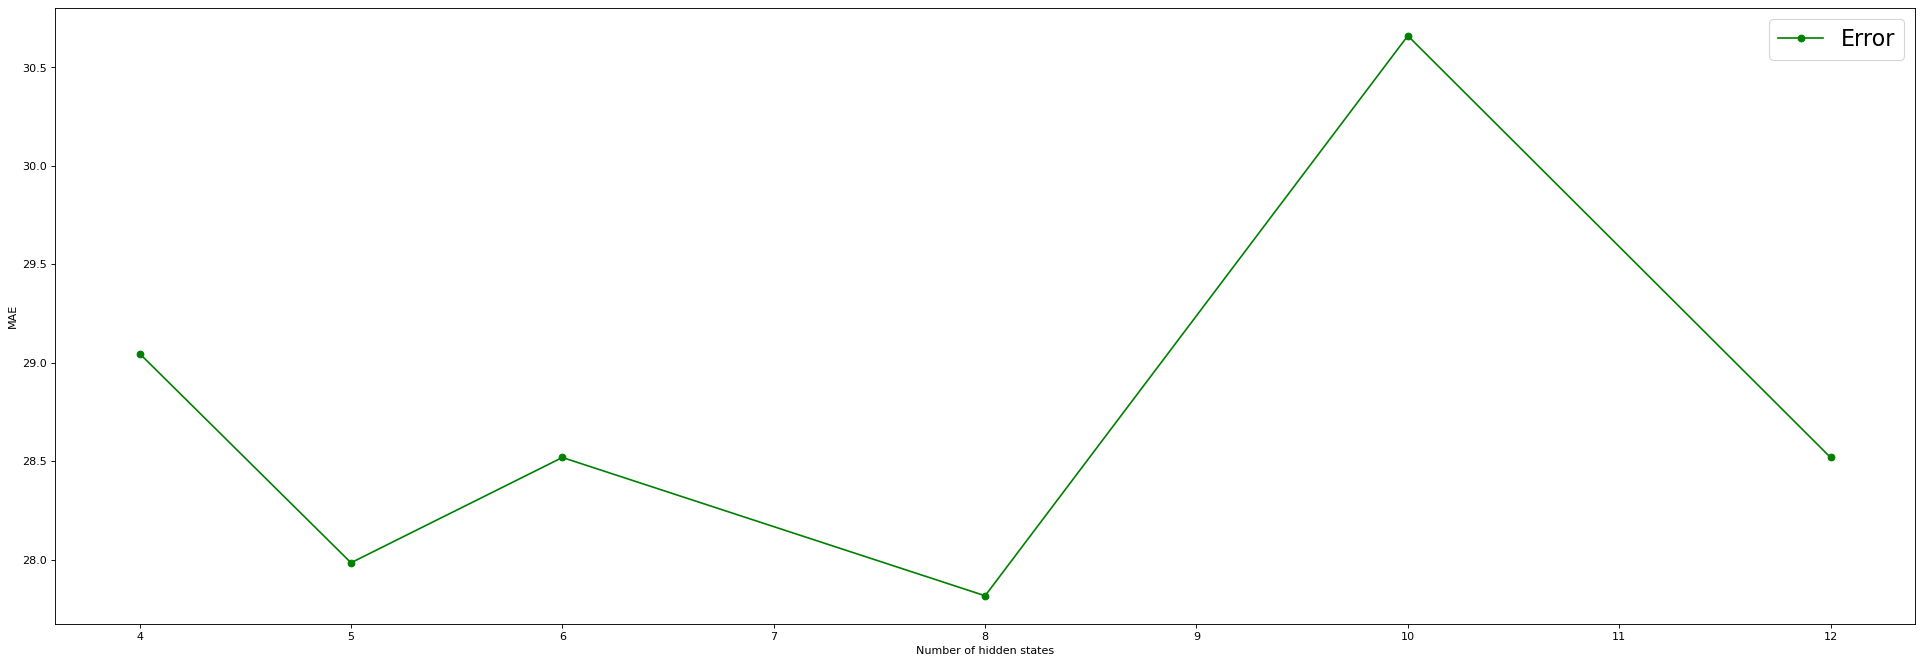

In [63]:
plt.figure(figsize=(30,10), dpi=80)

plt.plot(n_components_values, mae_num_components, 'go-', label="Error")
plt.xlabel("Number of hidden states")
plt.ylabel("MAE")
plt.legend(prop={'size': 20})
plt.show()

## Prédictions

In [65]:
model = GaussianHMM(8, random_state=rs)
model.fit(features_train)

GaussianHMM(n_components=8, random_state=3)

In [67]:
num_latent_days = 50
num_days_to_predict = 300

In [78]:
test_data

,Date,Open,High,Low,Close,Volume,Adjusted,Returns
3435,2020-08-25,3435.949951,3444.209961,3425.840088,3443.620117,3.627650e+09,3443.620117,0.003596
3436,2020-08-26,3449.969971,3481.070068,3444.149902,3478.729980,3.780530e+09,3478.729980,0.010196
3437,2020-08-27,3485.139893,3501.379883,3468.350098,3484.550049,3.955890e+09,3484.550049,0.001673
3438,2020-08-28,3494.689941,3509.229980,3484.320068,3508.010010,3.868510e+09,3508.010010,0.006733
3439,2020-08-31,3509.729980,3514.770020,3493.250000,3500.310059,4.348280e+09,3500.310059,-0.002195
...,...,...,...,...,...,...,...,...
4289,2024-01-18,4760.100098,4785.790039,4740.569824,4780.939941,4.019000e+09,4780.939941,0.008805
4290,2024-01-19,4796.279785,4842.069824,4785.870117,4839.810059,4.287200e+09,4839.810059,0.012314
4291,2024-01-22,4853.419922,4868.410156,4844.049805,4850.430176,4.297610e+09,4850.430176,0.002194
4292,2024-01-23,4856.799805,4866.479980,4844.370117,4864.600098,3.912800e+09,4864.600098,0.002921


In [69]:
predicted_close_prices = []
for i in tqdm(range(num_days_to_predict)):
    # Calculate start and end indices
    previous_data_start_index = max(0, i - num_latent_days)
    previous_data_end_index = max(0, i)
    # Acquire test data features for these days
    previous_data = extract_features(augment_features(test_data.iloc[previous_data_start_index:previous_data_end_index]))
    
    outcome_scores = []
    for outcome in possible_outcomes:
        # Append each outcome one by one with replacement to see which sequence generates the highest score
        total_data = np.row_stack((previous_data, outcome))
        outcome_scores.append(model.score(total_data))
        
    # Take the most probable outcome as the one with the highest score
    most_probable_outcome = possible_outcomes[np.argmax(outcome_scores)]
    predicted_close_prices.append(test_data.iloc[i]['Open'] * (1 + most_probable_outcome[0]))

100%|██████████| 300/300 [03:38<00:00,  1.37it/s]


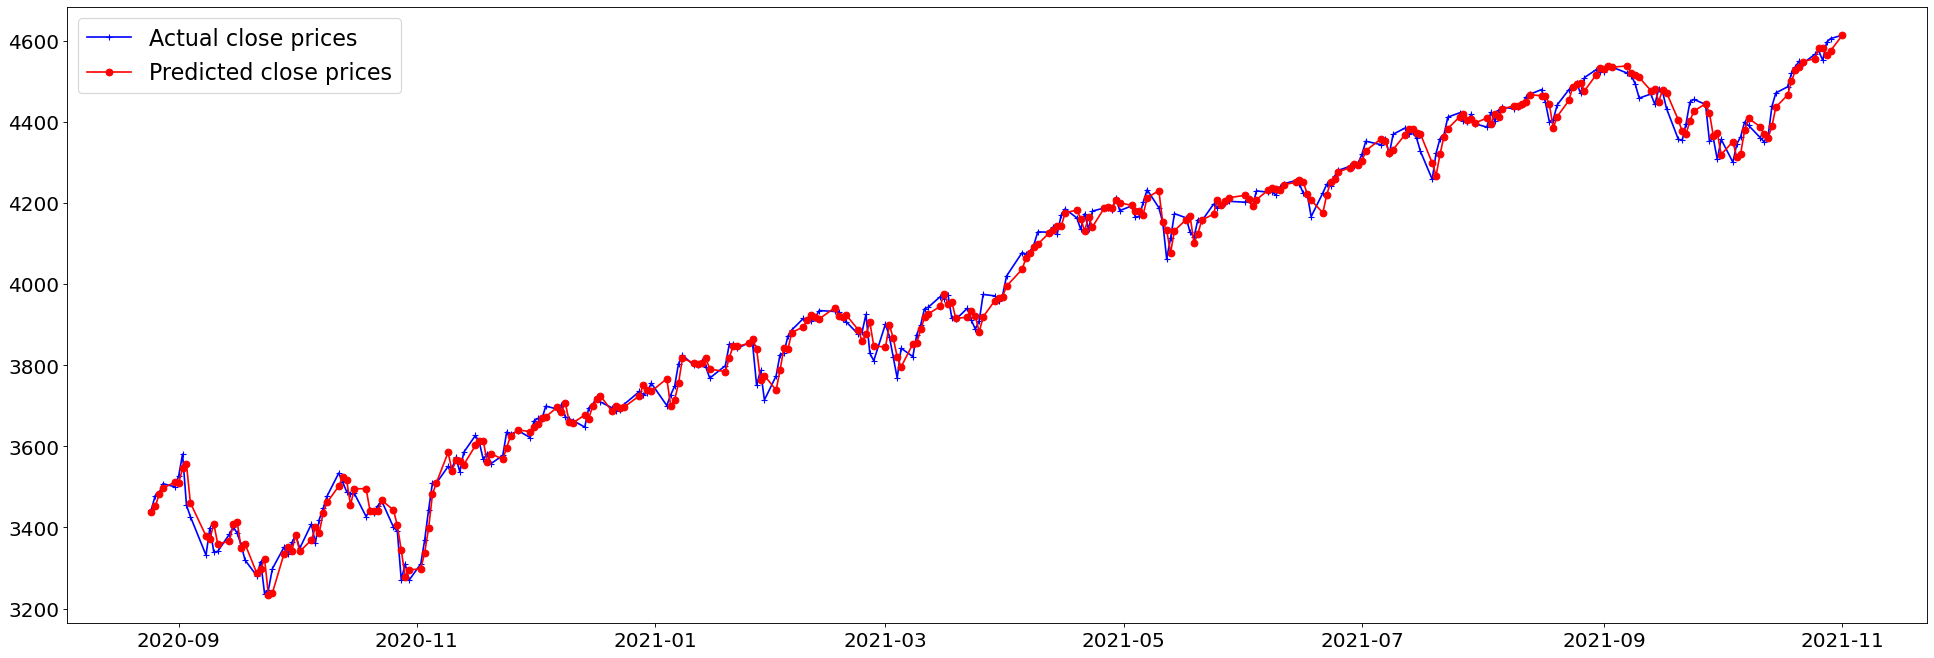

In [71]:
plt.figure(figsize=(30,10), dpi=80)
plt.rcParams.update({'font.size': 18})

x_axis = np.array(test_data['Date'][0:num_days_to_predict], dtype='datetime64[ms]')
plt.plot(x_axis, test_data.iloc[0:num_days_to_predict]['Close'], 'b+-', label="Actual close prices")
plt.plot(x_axis, predicted_close_prices, 'ro-', label="Predicted close prices")
plt.legend(prop={'size': 20})
plt.show()

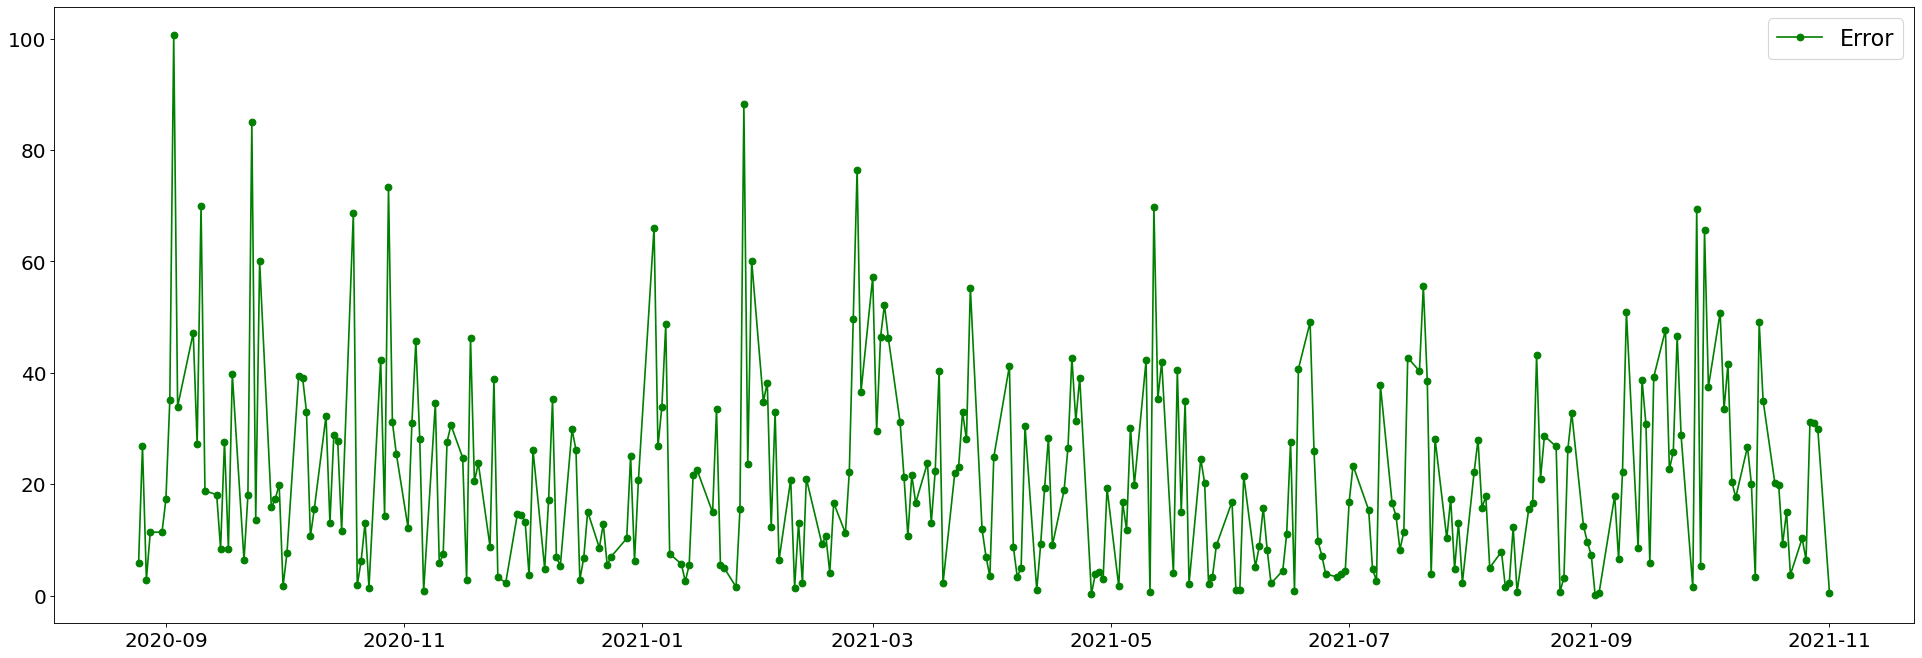

In [73]:
ae = abs(test_data.iloc[0:num_days_to_predict]['Close'] - predicted_close_prices)

plt.figure(figsize=(30,10), dpi=80)

plt.plot(x_axis, ae, 'go-', label="Error")
plt.legend(prop={'size': 20})
plt.show()

In [75]:
print("Mean Absolute error observed = " + str(ae.mean()))

Mean Absolute error observed = 21.35224945764211


## Paramètres

In [278]:
# Analyse des probabilités de transition et des statistiques des états
transition_matrix = model.transmat_

print("Matrice de Probabilités de Transition :")
print(transition_matrix)
print("\nMoyennes et Variances pour chaque état :")
for i in range(model.n_components):
    print(f"État {i}: Moyenne = {model.means_[i]}, Variance = {np.diag(model.covars_[i])}")

Matrice de Probabilités de Transition :
[[1.70454978e-03 1.48476803e-15 3.85942423e-05 2.84482126e-03
  4.11268706e-07 9.95411500e-01 1.23526598e-07 1.81848970e-14]
 [3.99723241e-03 3.11934427e-01 4.78191513e-16 2.26226227e-06
  3.20012275e-13 2.50760945e-14 3.67741230e-01 3.16324848e-01]
 [2.78405152e-20 1.85580673e-16 3.83516216e-07 5.01750925e-07
  9.21930593e-14 9.99993663e-01 2.80633395e-18 5.45168261e-06]
 [1.04368711e-01 1.68978921e-01 3.43289114e-06 2.42927338e-01
  6.02067777e-05 4.83660076e-01 3.26660225e-08 1.28204622e-06]
 [8.76780419e-04 1.42176958e-14 2.04456630e-06 9.99121119e-01
  5.55674483e-08 4.93703978e-11 2.07248931e-24 7.06119305e-21]
 [2.16148985e-04 8.12260744e-10 3.83073285e-02 8.20150169e-01
  1.03331918e-01 2.19786172e-02 6.14534028e-15 1.60158170e-02]
 [2.81563356e-10 4.54884115e-02 4.89922319e-22 1.21564100e-12
  1.30522391e-11 1.00765266e-05 8.66381851e-01 8.81196605e-02]
 [1.93652897e-07 4.48794583e-01 7.47013398e-08 1.01957344e-04
  5.91467135e-11 2.1756

## Prédictions

In [92]:
possible_outcomes[-1]
test_data.iloc[-1]

Date        2024-01-24 00:00:00
Open                4888.560059
High                4903.680176
Low                 4865.939941
Close               4868.549805
Volume             2675171000.0
Adjusted            4868.549805
Returns                0.000812
Name: 4293, dtype: object

In [104]:
# Ensure you have the last day's data from test_data
last_day_data = augment_features(test_data.iloc[-1:])
last_day_features = extract_features(last_day_data)

# Initialize a list to store scores for each possible outcome
outcome_scores = []

# Score each possible outcome
for outcome in possible_outcomes:
    total_data = np.row_stack((last_day_features, outcome))
    score = model.score(total_data)
    outcome_scores.append(score)

# Find the most probable outcome
most_probable_outcome = possible_outcomes[np.argmax(outcome_scores)]

# Predict next day's closing price
# Assuming 'Open' price is available for the day you are predicting
next_day_predicted_close = test_data['Open'].iloc[-1] * (1 + most_probable_outcome[0])

In [108]:
last_date = test_data['Date'].iloc[-1]

if not isinstance(last_date, datetime.datetime):
    last_date = datetime.datetime.strptime(last_date, '%Y-%m-%d')

next_day_date = last_date + datetime.timedelta(days=1)

next_day_date_str = next_day_date.strftime('%Y-%m-%d')

# Print the forecast with the next day's date
print("The forecasted price for " + next_day_date_str + " is: $" + format(next_day_predicted_close, '.2f'))


The forecasted price for 2024-01-25 is: $4891.28


True price according to yahoo Finance: $4,894.16